# Ejercicio 1
El archivo ecg.csv contiene 5,000 latidos cardíacos provenientes del dataset "ECG5000", una colección de
datos de electrocardiograma (ECG) de "BIDMC Congestive Heart Failure Database”. Cada fila representa un
ECG completo de un paciente, compuesto por 140 puntos de datos (lecturas). Cada fila contiene una
etiqueta que indica si el ECG es normal (valor 1) o anormal (valor 0). La versión original del archivo se
encuentra en: https://www.kaggle.com/datasets/devavratatripathy/ecg-dataset

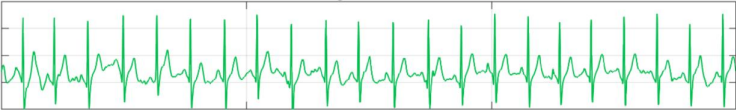

Desarrolle un modelo de autoencoder utilizando redes neuronales densas con TensorFlow/Keras que
posibilite diferenciar electrocardiogramas normales de anormales.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("csv/ecg.csv", header=None)
y = df.iloc[:, -1].astype(int)  # 0=anómalo, 1=normal
X = df.iloc[:, :-1].astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Filtramos SOLO normales para entrenar el autoencoder
X_train_norm = X_train[y_train == 1].copy()

# Escalador ajustado SOLO con normales
scaler = StandardScaler()
X_train_norm_scaled = scaler.fit_transform(X_train_norm)
X_test_scaled = scaler.transform(X_test)

n_features = X.shape[1]

In [ ]:
import numpy as np
from keras import Input, Model, layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score

inp = Input(shape=(n_features,))
# Encoder
h1 = layers.Dense(64, activation="relu")(inp)
h2 = layers.Dense(32, activation="relu")(h1)
z = layers.Dense(16, activation="relu", name="latente")(h2)
# Decoder
d1 = layers.Dense(32, activation="relu")(z)
d2 = layers.Dense(64, activation="relu")(d1)
out = layers.Dense(n_features, activation="linear")(d2)

ae = Model(inp, out)
ae.compile(optimizer=Adam(1e-3), loss="mse")

early = EarlyStopping(
    monitor="val_loss", mode="min", patience=10, restore_best_weights=True, verbose=1
)

hist = ae.fit(
    X_train_norm_scaled,
    X_train_norm_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[early],
    verbose=1,
)


def recon_error(ae_model, X):
    X_rec = ae_model.predict(X, verbose=0)
    # MSE por muestra
    return np.mean((X - X_rec) ** 2, axis=1)


# Umbral desde training normal (p.ej. percentil 99)
err_train_norm = recon_error(ae, X_train_norm_scaled)
thr = np.percentile(err_train_norm, 99.0)

# Predicciones
err_test = recon_error(ae, X_test_scaled)
y_pred_anom = (err_test > thr).astype(int)  # 1 = anómalo
y_pred = 1 - y_pred_anom  # 1=normal, 0=anómalo

print(f"Umbral (p99): {thr:.6e}")
print(classification_report(y_test, y_pred, digits=4))
auc = roc_auc_score(1 - y_test, err_test)  # positivos = anómalos
print(f"AUC (anomalía vs error): {auc:.4f}")

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.8880 - val_loss: 0.7989
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6108 - val_loss: 0.5661
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4527 - val_loss: 0.4135
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3464 - val_loss: 0.3441
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2988 - val_loss: 0.3116
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2750 - val_loss: 0.2965
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2610 - val_loss: 0.2813
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2465 - val_loss: 0.2669
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2341 - val_loss: 0.2576
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2215 - val_loss: 0.2415
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2092 - val_loss: 0.2309
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

# Ejercicio 2
Desarrolle un modelo de autoencoder que permita detectar transacciones realizadas con tarjetas de crédito
fraudulentas.
Utilice el dataset creditcard.csv provisto en la carpeta de datos del Moodle o descárguelo desde el enlace:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud. Este presenta transacciones que ocurrieron en
dos días, donde se detectaron 492 fraudes de un total de 284,807 transacciones. Los datos están altamente
desbalanceados, ya que la clase positiva (fraudes) representa menos del 0.2% de todas las transacciones.

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("csv/creditcard.csv")

x = df.drop(labels=["Class"], axis=1)
y = df["Class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

x_real_train = x_train_norm[y_train == 0]
x_fraudulent_train = x_train_norm[y_train == 1]
x_real_test = x_test_norm[y_test == 0]
x_fraudulent_test = x_test_norm[y_test == 1]


Epoch 1/400


c:\Users\frank\Documents\GitHub\4to-anio-unlp-sistemas\deeplearning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3767 - val_loss: 0.2945
Epoch 2/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2780 - val_loss: 0.2632
Epoch 3/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2560 - val_loss: 0.2491
Epoch 4/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2438 - val_loss: 0.2378
Epoch 5/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2367 - val_loss: 0.2325
Epoch 6/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2313 - val_loss: 0.2270
Epoch 7/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2266 - val_loss: 0.2218
Epoch 8/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2227 - val_loss: 0.2198
Epoch 9/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2199 - val_loss: 0.2181
Epoch 10/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2182 - val_loss: 0.2204
Epoch 11/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2173 - val_loss: 0.2203
Epoch 12/400
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

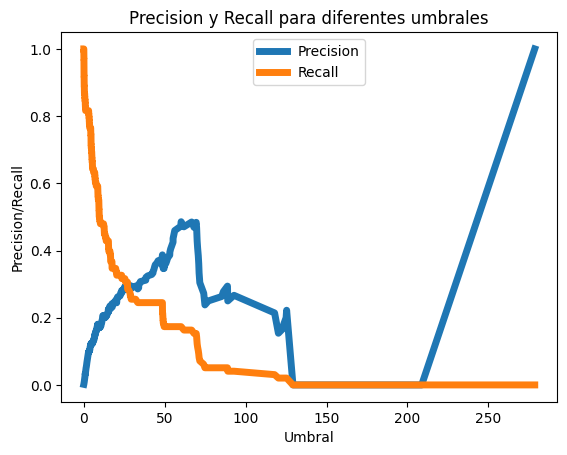

In [27]:
from keras import Input, layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import MeanAbsoluteError

import matplotlib.pyplot as plt

model = Sequential(
    [
        layers.Dense(30, activation="relu", name="en1", input_shape=(n_features,)),
        layers.Dense(10, activation="linear", name="latente"),
        layers.Dense(30, activation="relu", name="de2"),
        layers.Dense(n_features, activation="linear", name="out"),
    ]
)
adam = Adam(learning_rate=0.01)
model.compile(adam, loss=MeanAbsoluteError())
es = EarlyStopping(
    "val_loss", min_delta=1e-8, patience=5, verbose=1, restore_best_weights=True
)
history = model.fit(
    x_real_train,
    x_real_train,
    epochs=400,
    batch_size=800,
    validation_split=0.2,
    callbacks=[es],
    verbose=1,
    shuffle=True
)


reconstruccion = model.predict(x_test_norm) # Predecimos los tests
ecm = np.mean(np.power(x_test_norm-reconstruccion,2), axis=1) # Calculamos el ERROR CUADRATICO MEDIO

# Gráfica precision-recall para determinar el umbral
from sklearn.metrics import precision_recall_curve
precision, recall, umbral = precision_recall_curve(y_test, ecm) 

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix
# Matriz de confusión
umbral_fijo = 0.9
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

conf_matrix = confusion_matrix(y_test, Y_pred)
print(conf_matrix)

report = classification_report(y_test,Y_pred)
print("Confusion matrix Training:\n%s" % report) 

[[54516  2348]
 [   16    82]]
Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.84      0.06        98

    accuracy                           0.96     56962
   macro avg       0.52      0.90      0.52     56962
weighted avg       1.00      0.96      0.98     56962



# Ejercicio 3
El dataset Landscape Image Colorization consta de 7219 imágenes de calles, edificios, montañas, glaciares,
y árboles, entre otros. Este contiene dos versiones de cada imagen: una en escala de grises y otra en color,
almacenadas en dos carpetas separadas. La versión original de este archivo está disponible en:
https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization/data

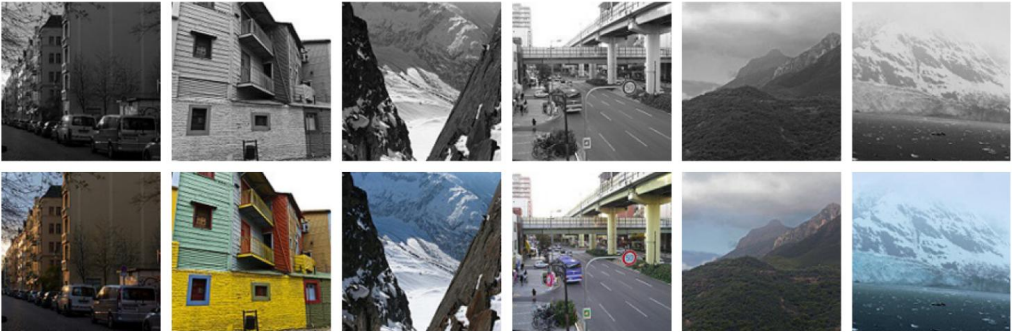

Desarrolle un modelo de autoencoder que permita generar versiones a color de imágenes en escala de
grises. Utilice capas convolucionales tanto en el bloque codificador como decodificador.
Dado que en la etapa del decodificador requiere capas para aumentar la dimensión para formar la imagen
final, implemente 3 versiones diferentes:

a) Utilizando capas Upsampling2D.

b) Utilizando capas Reescale.

c) Utilizando capas Conv2DTranspose.

Luego de entrenados los distintos modelos compare los resultados de las imágenes coloreadas. 

In [32]:
import zipfile
from pathlib import Path
import tensorflow as tf

# === 1) Rutas de entrada/salida ===
zip_path = r"csv\landscape_color_gray.zip"     # <- CAMBIA esto
extract_root = Path(r"./csv/images")  # <- CAMBIA esto (carpeta donde extraer)

extract_root.mkdir(parents=True, exist_ok=True)

# === 2) Extraer el ZIP ===
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_root)

# === 3) Localizar la carpeta 'landscape Images' sin importar mayúsculas/espacios ===
candidates = [
    p for p in extract_root.rglob("*")
    if p.is_dir() and p.name.lower().replace("_", " ").replace("-", " ") == "landscape images"
]
if not candidates:
    # Si ya estás parado justo en esa carpeta, también sirve:
    # usa extract_root si ahí están las subcarpetas 'color' y 'gray'
    if (extract_root / "color").is_dir() and (extract_root / "gray").is_dir():
        data_dir = extract_root
    else:
        raise FileNotFoundError("No se encontró la carpeta 'landscape Images' ni subcarpetas 'color' y 'gray'.")
else:
    data_dir = candidates[0]

# Verificación mínima
assert (data_dir / "color").is_dir() and (data_dir / "gray").is_dir(), \
    "Faltan subcarpetas 'color' y/o 'gray' dentro de 'landscape Images'."

img_size = (224, 224)
batch_size = 32
seed = 42
val_split = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',           # clases = nombres de subcarpetas: ['color', 'gray']
    label_mode='categorical',    # one-hot (útil para modelos con softmax)
    validation_split=val_split,
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb'             # unifica a 3 canales
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=val_split,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb'
)


# === 5) Guardar class_names ANTES de cache/prefetch ===
class_names = train_ds.class_names
print("Clases detectadas:", class_names)  # ['color', 'gray']

# === 5b) Optimizar pipeline (cache/prefetch) DESPUÉS de leer class_names ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

# === 7) Chequeo rápido  ===
for images, labels in train_ds.take(1):
    print("Batch de imágenes:", images.shape)
    print("Batch de labels:", labels.shape)

Found 14258 files belonging to 2 classes.
Using 11407 files for training.
Found 14258 files belonging to 2 classes.
Using 2851 files for validation.
Clases detectadas: ['color', 'gray']
Batch de imágenes: (32, 224, 224, 3)
Batch de labels: (32, 2)


In [ ]:
# Entrenamiento de un MF autoencoder

# === (a) Autoencoder con decoder UpSampling2D, encadenado a TU pipeline existente ===
# Tomamos tus train_ds / val_ds (rgb,+labels), ignoramos labels y generamos (Y -> UV)

import tensorflow as tf
from tensorflow.keras import layers, models

# 1) Quitar labels y mapear a (Y, UV_target)
AUTOTUNE = tf.data.AUTOTUNE

@tf.function
def to_y_uv(rgb):
    rgb = tf.cast(rgb, tf.float32) / 255.0
    yuv = tf.image.rgb_to_yuv(rgb)          # Y in [0,1]; U,V ~ [-0.5,0.5]
    y  = yuv[..., :1]
    uv = yuv[..., 1:] * 2.0                 # target en [-1,1] para tanh
    return y, uv

train_pairs = train_ds.map(lambda x, y: x, num_parallel_calls=AUTOTUNE) \
                      .map(to_y_uv, num_parallel_calls=AUTOTUNE) \
                      .cache().shuffle(1000).prefetch(AUTOTUNE)

val_pairs   = val_ds.map(lambda x, y: x, num_parallel_calls=AUTOTUNE) \
                    .map(to_y_uv, num_parallel_calls=AUTOTUNE) \
                    .cache().prefetch(AUTOTUNE)

# 2) Modelo encoder–decoder (UpSampling2D)
def conv_block(x, f, k=3, s=1):
    x = layers.Conv2D(f, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def up_block(x, f):
    x = layers.UpSampling2D(2, interpolation="nearest")(x)  # (a)
    x = conv_block(x, f, 3, 1)
    x = conv_block(x, f, 3, 1)
    return x

H, W = 224, 224
inp = layers.Input(shape=(H, W, 1))  # Y

# Encoder (downsample por stride=2)
x = conv_block(inp,  64, 3, 1)
x = conv_block(x,    64, 3, 2)  # /2
x = conv_block(x,   128, 3, 1)
x = conv_block(x,   128, 3, 2)  # /4
x = conv_block(x,   256, 3, 1)
x = conv_block(x,   256, 3, 2)  # /8
x = conv_block(x,   512, 3, 1)
x = conv_block(x,   512, 3, 2)  # /16 (bottleneck)

# Decoder (upsampling x2)
x = up_block(x, 256)            # /8
x = up_block(x, 128)            # /4
x = up_block(x,  64)            # /2
x = up_block(x,  32)            # /1

out_uv = layers.Conv2D(2, 1, padding="same", activation="tanh")(x)  # UV en [-1,1]

model_a = models.Model(inp, out_uv)
model_a.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mae",
    metrics=[tf.keras.metrics.MeanSquaredError(name="mse")]
)
model_a.summary()

# 3) Entrenamiento
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
]
history_a = model_a.fit(
    train_pairs,
    validation_data=val_pairs,
    epochs=40,
    callbacks=callbacks
)

# 4) Inferencia y reconstrucción RGB (rápida)
def predict_rgb(batch_y, pred_uv):
    uv = pred_uv / 2.0                         # [-1,1] -> [-0.5,0.5]
    yuv = tf.concat([batch_y, uv], axis=-1)    # [B,H,W,3]
    rgb = tf.image.yuv_to_rgb(yuv)
    return tf.clip_by_value(rgb, 0.0, 1.0)

for y_batch, uv_tgt in val_pairs.take(1):
    uv_pred  = model_a.predict(y_batch, verbose=0)
    rgb_pred = predict_rgb(y_batch, uv_pred)   # [0,1]
    print("Reconstrucción:", rgb_pred.shape)   # (B, 224, 224, 3)
    break

# 5) Métricas perceptuales simples (PSNR/SSIM) sobre unas batches
def psnr_ssim(ds, max_batches=3):
    psnr_list, ssim_list = [], []
    n = 0
    for y_b, uv_t in ds:
        uv_p  = model_a.predict(y_b, verbose=0)
        rgb_p = predict_rgb(y_b, uv_p)

        # truth RGB desde (Y, UV_target)
        rgb_t = predict_rgb(y_b, uv_t)

        psnr_list.append(tf.image.psnr(rgb_t, rgb_p, max_val=1.0))
        ssim_list.append(tf.image.ssim(rgb_t, rgb_p, max_val=1.0))
        n += 1
        if n >= max_batches:
            break
    return tf.concat(psnr_list, 0).numpy().mean(), tf.concat(ssim_list, 0).numpy().mean()

psnr_a, ssim_a = psnr_ssim(val_pairs, max_batches=3)
print(f"(a) PSNR≈{psnr_a:.2f}  SSIM≈{ssim_a:.3f}")
